# DDGun3D
## process both FoldX and DDGun3D

In [1]:
import pandas
import numpy
from copy import deepcopy

import math
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
#foldx_df = pandas.read_csv("../FoldX/Ssym+_experimental.csv", index_col=0)#,usecols=['Protein', 'Mut_pdb','DDG_dir','DDG_inv','FoldX_dir','FoldX_inv']) #.drop(["Unnamed: 0","guess"], axis=1)
#display(foldx_df.head())
#print(foldx_df.columns)

In [3]:
foldx_df = pandas.read_csv("../FoldX/Ssym+_experimental.csv", index_col=0,usecols=['Protein', 'Mut_pdb','Mut_pdb_inv','DDG_dir','DDG_inv','FoldX_dir','FoldX_inv','DDGun3D_dir', 'DDGun3D_inv']) #.drop(["Unnamed: 0","guess"], axis=1)
foldx_df

,Mut_pdb,DDG_dir,DDG_inv,FoldX_dir,FoldX_inv,DDGun3D_dir,DDGun3D_inv,Mut_pdb_inv
Protein,,,,,,,,
1amqA,C191F,-1.60,1.60,-3.458090,-1.167050,0.9,-1.0,F191C
1amqA,C191S,-1.90,1.90,0.178326,-0.117104,-0.5,0.4,S191C
1amqA,C191W,-3.90,3.90,-6.466620,-1.234990,1.0,-1.1,W191C
1amqA,C191Y,-2.30,2.30,-1.795960,0.509656,1.3,-1.4,Y191C
1arrA,P8L,2.49,-2.49,-0.710842,-5.194210,0.1,-0.1,L8P
...,...,...,...,...,...,...,...,...
5ptiA,F22A,-1.20,1.20,-3.354030,0.428306,-2.5,2.8,A22F
5ptiA,F45A,-6.90,6.90,-3.351550,3.440730,-4.4,3.7,A45F
5ptiA,N43G,-5.70,5.70,-1.977350,-0.783265,-1.9,1.5,G43N


In [4]:
_dir=foldx_df.iloc[:,[0,1,5]].rename({'Mut_pdb': 'mut','DDG_dir': 'ddg','DDGun3D_dir':'ddgun3d'},axis=1)
_dir.head()

,mut,ddg,ddgun3d
Protein,,,
1amqA,C191F,-1.60,0.9
1amqA,C191S,-1.90,-0.5
1amqA,C191W,-3.90,1.0
1amqA,C191Y,-2.30,1.3
1arrA,P8L,2.49,0.1


In [5]:
_dir[['ddg','ddgun3d']].corr()

,ddg,ddgun3d
ddg,1.000000,0.583802
ddgun3d,0.583802,1.000000


In [6]:
_inv=foldx_df.iloc[:,[7,2,6]].rename({'Mut_pdb_inv': 'mut','DDG_inv': 'ddg','DDGun3D_inv':'ddgun3d'},axis=1)
_inv.head()

,mut,ddg,ddgun3d
Protein,,,
1amqA,F191C,1.60,-1.0
1amqA,S191C,1.90,0.4
1amqA,W191C,3.90,-1.1
1amqA,Y191C,2.30,-1.4
1arrA,L8P,-2.49,-0.1


In [7]:
foldx_train=pandas.concat([_dir,_inv])
foldx_train.head(), foldx_train.shape

(           mut   ddg  ddgun3d
 Protein                      
 1amqA    C191F -1.60      0.9
 1amqA    C191S -1.90     -0.5
 1amqA    C191W -3.90      1.0
 1amqA    C191Y -2.30      1.3
 1arrA      P8L  2.49      0.1,
 (704, 3))

,ddg,ddgun3d
ddg,1.000000,0.661139
ddgun3d,0.661139,1.000000


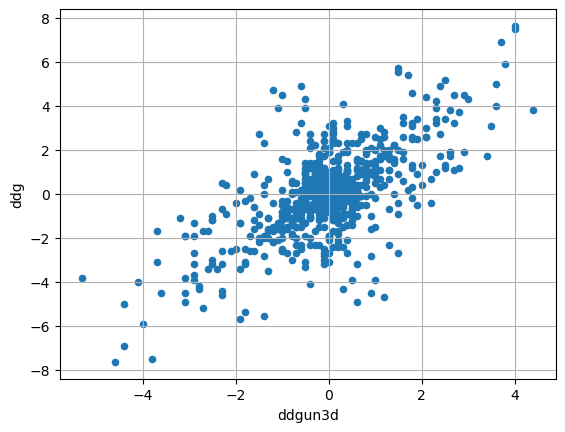

In [8]:
plain_foldx_plot= foldx_train.plot.scatter(x="ddgun3d", y="ddg", grid=True)
foldx_train[['ddg','ddgun3d']].corr()

## compute Rose USC

In [9]:
def unpack_mut(x):
    x['from_aa']= x['mut'][0]
    x['to_aa']= x['mut'][-1]
    return x
    
foldx_train=foldx_train.apply(unpack_mut,axis=1)
foldx_train.head()

,mut,ddg,ddgun3d,from_aa,to_aa
Protein,,,,,
1amqA,C191F,-1.60,0.9,C,F
1amqA,C191S,-1.90,-0.5,C,S
1amqA,C191W,-3.90,1.0,C,W
1amqA,C191Y,-2.30,1.3,C,Y
1arrA,P8L,2.49,0.1,P,L


In [10]:
rose=pandas.read_csv('rose1985.csv', index_col='Parameter')
rose

,Rose1985
Parameter,
A,86.6
C,132.3
D,97.8
E,113.9
F,194.1
G,62.9
H,155.8
I,158.0
K,115.5


In [11]:
#esmif_df.head()
def rose_delta(x):
    x['rose_delta']=rose['Rose1985'][x['from_aa']] - rose['Rose1985'][x['to_aa']]
    return x
    
foldx_train = foldx_train.apply(rose_delta, 
               axis=1
              )

In [12]:
foldx_train.head()

,mut,ddg,ddgun3d,from_aa,to_aa,rose_delta
Protein,,,,,,
1amqA,C191F,-1.60,0.9,C,F,-61.8
1amqA,C191S,-1.90,-0.5,C,S,46.7
1amqA,C191W,-3.90,1.0,C,W,-92.3
1amqA,C191Y,-2.30,1.3,C,Y,-45.4
1arrA,P8L,2.49,0.1,P,L,-71.2


In [13]:
X_fep= foldx_train[['ddgun3d','rose_delta']].to_numpy()
y= foldx_train['ddg'].to_numpy()

In [14]:
rose_model = LinearRegression(fit_intercept=False).fit(
    X_fep,
    y,
)

rose_model.coef_, rose_model.intercept_, math.sqrt(rose_model.score(X_fep, y))

(array([1.23259228, 0.00751656]), 0.0, 0.6718380131058596)

In [15]:
foldx_train['ddfep_rose']=rose_model.predict(X_fep)

1.4532699605074528

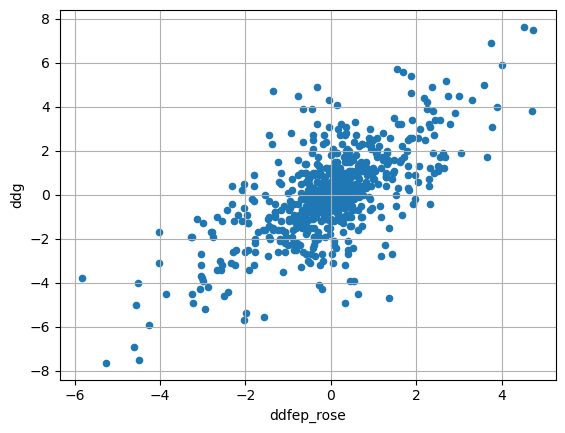

In [16]:
rose_plot= foldx_train.plot.scatter(x='ddfep_rose',y='ddg', grid=True)
math.sqrt(mean_squared_error(foldx_train['ddg'],foldx_train['ddfep_rose']))

In [17]:
foldx_train[['ddg','ddgun3d','ddfep_rose']].corr()

,ddg,ddgun3d,ddfep_rose
ddg,1.000000,0.661139,0.671968
ddgun3d,0.661139,1.000000,0.983933
ddfep_rose,0.671968,0.983933,1.000000


In [18]:
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
rsq=cross_val_score(LinearRegression(fit_intercept=True),
                   X_fep,y,
                   cv=RepeatedStratifiedKFold(n_splits=5,
                                              n_repeats=10,
                                              random_state=2411
                                              #shuffle=True,
                                             ).split(X_fep, y > 0))
rsq

array([0.40954599, 0.49750532, 0.50990993, 0.28790839, 0.50221125,
       0.41499222, 0.45518133, 0.37620821, 0.51544868, 0.47882883,
       0.33797016, 0.45173808, 0.5070882 , 0.43439033, 0.47602549,
       0.36361437, 0.57364064, 0.31755944, 0.48387049, 0.41671131,
       0.3675311 , 0.46909818, 0.5046023 , 0.36862034, 0.4691456 ,
       0.36075019, 0.45597184, 0.51187742, 0.4408516 , 0.43364134,
       0.27357192, 0.47647406, 0.40490882, 0.52711004, 0.46766302,
       0.38795899, 0.41048259, 0.47208763, 0.50657822, 0.44571433,
       0.32965154, 0.44219693, 0.41048249, 0.55487006, 0.50463929,
       0.48114307, 0.38924003, 0.37392827, 0.48535842, 0.49570321])

In [19]:
math.sqrt(rsq.mean()) , math.sqrt(rsq.std())

(0.6638102360675825, 0.25918270610840094)

## ddFEP

In [20]:
aa_labels = [
    "A",
    "R",
    "N",
    "D",
    "C",
    "Q",
    "E",
    "G",
    "H",
    "I",
    "L",
    "K",
    "M",
    "F",
    "P",
    "S",
    "T",
    "W",
    "Y",
    "V",
]

In [21]:
ddfep_opt = deepcopy(foldx_train)
for _ in sorted(aa_labels):
    ddfep_opt[_] = 0
ddfep_opt

,mut,ddg,ddgun3d,from_aa,to_aa,rose_delta,ddfep_rose,A,C,D,...,M,N,P,Q,R,S,T,V,W,Y
Protein,,,,,,,,,,,,,,,,,,,,,
1amqA,C191F,-1.60,0.9,C,F,-61.8,0.644810,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1amqA,C191S,-1.90,-0.5,C,S,46.7,-0.265273,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1amqA,C191W,-3.90,1.0,C,W,-92.3,0.538814,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1amqA,C191Y,-2.30,1.3,C,Y,-45.4,1.261118,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1arrA,P8L,2.49,0.1,P,L,-71.2,-0.411920,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5ptiA,A22F,1.20,2.8,A,F,-107.5,2.643228,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5ptiA,A45F,6.90,3.7,A,F,-107.5,3.752561,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5ptiA,G43N,5.70,1.5,G,N,-40.4,1.545219,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
def encode_mutation(x):
    x[x['from_aa']]= -1
    x[x['to_aa']] = 1
    return x

In [23]:
ddfep_opt = ddfep_opt.apply(encode_mutation, axis='columns')
ddgun_train=deepcopy(ddfep_opt)

In [24]:
### fit test

In [25]:
X_optfep= ddfep_opt[['ddgun3d']+sorted(aa_labels)].to_numpy()
y=ddfep_opt['ddg'].to_numpy()
X_optfep.shape, y.shape

((704, 21), (704,))

In [26]:
dd_optfep_model = LinearRegression(fit_intercept=False).fit(
    X_optfep,
    y,
)

In [27]:
dd_optfep_model.coef_, dd_optfep_model.intercept_, math.sqrt(dd_optfep_model.score(X_optfep, y))

(array([ 1.31290971,  0.36976042,  1.01285819,  0.01691286,  0.50403965,
        -0.71821607,  0.6969495 , -0.97736541, -0.19433086,  0.56510755,
        -0.38503383,  0.01949975,  0.53976652,  0.06795002,  0.45048807,
         1.34724612,  0.33979634,  0.63991281, -0.16909184, -3.6080607 ,
        -0.51818909]),
 0.0,
 0.7396650812122517)

#### ddMBC coefs

In [28]:
kd = {
    "A": 1.800,
    "R": -4.500,
    "N": -3.500,
    "D": -3.500,
    "C": 2.500,
    "Q": -3.500,
    "E": -3.500,
    "G": -0.400,
    "H": -3.200,
    "I": 4.500,
    "L": 3.800,
    "K": -3.900,
    "M": 1.900,
    "F": 2.800,
    "P": -1.600,
    "S": -0.800,
    "T": -0.700,
    "W": -0.900,
    "Y": -1.300,
    "V": 4.200,
}

In [29]:
ddfep_opt['ddfep_opt']=dd_optfep_model.predict(X_optfep)

RMSE: 1.3203956890674604


,ddg,ddfep_opt
ddg,1.000000,0.739799
ddfep_opt,0.739799,1.000000


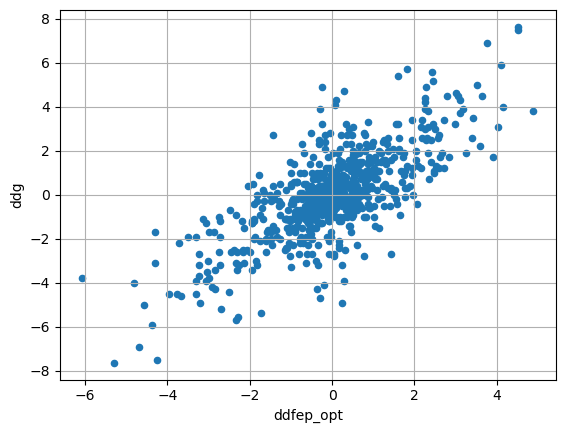

In [30]:
ddfep_opt_plot = ddfep_opt.plot.scatter(x='ddfep_opt',y='ddg', grid=True)

print('RMSE:',math.sqrt(mean_squared_error(ddfep_opt['ddg'],ddfep_opt['ddfep_opt'])))
ddfep_opt[['ddg','ddfep_opt']].corr()

### Crossvalidate

In [31]:
optfep_rsq=cross_val_score(LinearRegression(fit_intercept=True),
                   X_optfep,y,
                   cv=RepeatedStratifiedKFold(n_splits=5,
                                              n_repeats=10,
                                              #shuffle=True,
                                             ).split(X_optfep, y > 0))
optfep_rsq

array([0.51881979, 0.57099773, 0.5046141 , 0.5097636 , 0.46974183,
       0.52654188, 0.54010947, 0.54705911, 0.43544609, 0.43004376,
       0.51265385, 0.52300887, 0.54645018, 0.41966615, 0.48600878,
       0.5033191 , 0.41066248, 0.54987781, 0.52292381, 0.52947202,
       0.60671624, 0.40108315, 0.5631286 , 0.4801523 , 0.46266685,
       0.46227953, 0.39293781, 0.51080646, 0.58844676, 0.61383888,
       0.55575501, 0.40145526, 0.57768936, 0.47525162, 0.51663464,
       0.47618348, 0.56571763, 0.52269074, 0.50101808, 0.48798649,
       0.57662786, 0.53160689, 0.59140343, 0.44581395, 0.42261609,
       0.52429785, 0.57300174, 0.39501446, 0.50382124, 0.51527747])

In [32]:
_r=numpy.sqrt(optfep_rsq)
_r.mean(), _r.std()

(np.float64(0.710132870122521), np.float64(0.04114988127086299))

## Test on S669

In [33]:
_669_foldx = pandas.read_csv(
    "../FoldX/Data_s669_with_predictions.csv",
    index_col=None,
    usecols=["Protein", "PDB_Mut", "FoldX_dir", "FoldX_inv","DDGun3D_dir",'DDGun3D_inv', "DDG_checked_dir", "DDG_checked_inv"],
)
_669_foldx["hash"] = _669_foldx.apply(
    lambda x: "_".join([x["Protein"], x["PDB_Mut"]]), axis=1
)
_669_foldx['experimental']=True
_669_foldx
# list(_669_foldx.columns)

,Protein,PDB_Mut,DDG_checked_dir,FoldX_dir,DDGun3D_dir,FoldX_inv,DDG_checked_inv,DDGun3D_inv,hash,experimental
0,1A0FA,S11A,-1.800,0.551703,0.5,-0.571577,1.800,-0.5,1A0FA_S11A,True
1,1A7VA,A104H,-2.690,0.562630,-0.1,-0.820657,2.690,0.1,1A7VA_A104H,True
2,1A7VA,A66H,-1.980,-0.395478,0.5,-0.228698,1.980,-0.5,1A7VA_A66H,True
3,1A7VA,A91H,-1.700,0.045107,-0.1,-0.590049,1.700,0.1,1A7VA_A91H,True
4,1A7VA,D3H,-1.360,-3.565060,0.2,0.056278,1.360,-0.2,1A7VA_D3H,True
...,...,...,...,...,...,...,...,...,...,...
664,5JXBA,D329P,-1.440,-0.778776,-0.2,NaN,1.440,0.0,5JXBA_D329P,True
665,5OAQA,Y429H,-2.990,-3.408590,-2.4,1.961710,2.990,2.4,5OAQA_Y429H,True
666,5VP3A,R39K,0.413,-0.621078,-1.0,0.093390,-0.413,1.0,5VP3A_R39K,True
667,5VP3A,S128G,-0.378,-1.227820,-0.8,-0.960481,0.378,0.8,5VP3A_S128G,True


In [34]:
_461_muts = pandas.read_csv("../FoldX/s461_muts.csv", sep=" ")

s461_hashes = set(_461_muts.apply(lambda x: "_".join([x["pdb"], x["mut"]]), axis=1))
_461_muts.head()

,pdb,mut,ddg
0,1A0FA,S11A,-1.800
1,1BA3A,H461D,-1.745
2,1BA3A,H489D,0.287
3,1BA3A,H489K,-0.287
4,1BA3A,H489M,-0.263


In [35]:
_669_foldx['s461']=_669_foldx.apply( lambda x: x['hash'] in s461_hashes, axis=1)
#_669_foldx['FoldX_inv'] = - _669_foldx['FoldX_inv']
_669_foldx.head()

,Protein,PDB_Mut,DDG_checked_dir,FoldX_dir,DDGun3D_dir,FoldX_inv,DDG_checked_inv,DDGun3D_inv,hash,experimental,s461
0,1A0FA,S11A,-1.80,0.551703,0.5,-0.571577,1.80,-0.5,1A0FA_S11A,True,True
1,1A7VA,A104H,-2.69,0.562630,-0.1,-0.820657,2.69,0.1,1A7VA_A104H,True,False
2,1A7VA,A66H,-1.98,-0.395478,0.5,-0.228698,1.98,-0.5,1A7VA_A66H,True,False
3,1A7VA,A91H,-1.70,0.045107,-0.1,-0.590049,1.70,0.1,1A7VA_A91H,True,False
4,1A7VA,D3H,-1.36,-3.565060,0.2,0.056278,1.36,-0.2,1A7VA_D3H,True,False


In [36]:
_669_foldx['revmut']=_669_foldx['PDB_Mut'].apply(lambda x: ''.join([x[-1],x[1:-1],x[0]]))
_669_foldx.head()

,Protein,PDB_Mut,DDG_checked_dir,FoldX_dir,DDGun3D_dir,FoldX_inv,DDG_checked_inv,DDGun3D_inv,hash,experimental,s461,revmut
0,1A0FA,S11A,-1.80,0.551703,0.5,-0.571577,1.80,-0.5,1A0FA_S11A,True,True,A11S
1,1A7VA,A104H,-2.69,0.562630,-0.1,-0.820657,2.69,0.1,1A7VA_A104H,True,False,H104A
2,1A7VA,A66H,-1.98,-0.395478,0.5,-0.228698,1.98,-0.5,1A7VA_A66H,True,False,H66A
3,1A7VA,A91H,-1.70,0.045107,-0.1,-0.590049,1.70,0.1,1A7VA_A91H,True,False,H91A
4,1A7VA,D3H,-1.36,-3.565060,0.2,0.056278,1.36,-0.2,1A7VA_D3H,True,False,H3D


In [37]:
_669_dir=_669_foldx.iloc[:,[0,1,2,4,-3,-2]].rename({'PDB_Mut': 'mut','DDG_checked_dir': 'ddg','DDGun3D_dir':'ddgun3d'},axis=1).apply(unpack_mut, axis=1)
_669_dir.head()

,Protein,mut,ddg,ddgun3d,experimental,s461,from_aa,to_aa
0,1A0FA,S11A,-1.80,0.5,True,True,S,A
1,1A7VA,A104H,-2.69,-0.1,True,False,A,H
2,1A7VA,A66H,-1.98,0.5,True,False,A,H
3,1A7VA,A91H,-1.70,-0.1,True,False,A,H
4,1A7VA,D3H,-1.36,0.2,True,False,D,H


In [38]:
_669_dir[['ddg','ddgun3d']].corr()

,ddg,ddgun3d
ddg,1.000000,0.432432
ddgun3d,0.432432,1.000000


In [39]:
_669_inv=_669_foldx.iloc[:,[0,6,7,-3,-2,-1]].rename({'revmut': 'mut','DDG_checked_inv': 'ddg','DDGun3D_inv':'ddgun3d'},axis=1).apply(unpack_mut, axis=1)
_669_inv['experimental']= False
_669_inv.head()

,Protein,ddg,ddgun3d,experimental,s461,mut,from_aa,to_aa
0,1A0FA,1.80,-0.5,False,True,A11S,A,S
1,1A7VA,2.69,0.1,False,False,H104A,H,A
2,1A7VA,1.98,-0.5,False,False,H66A,H,A
3,1A7VA,1.70,0.1,False,False,H91A,H,A
4,1A7VA,1.36,-0.2,False,False,H3D,H,D


In [40]:
_669_inv[['ddg','ddgun3d']].corr()

,ddg,ddgun3d
ddg,1.000000,0.410487
ddgun3d,0.410487,1.000000


In [41]:
_669_full=pandas.concat([_669_dir,_669_inv], ignore_index=True)
_669_full.shape

(1338, 8)

In [42]:
_669_full[['ddg','ddgun3d']].corr()

,ddg,ddgun3d
ddg,1.000000,0.568375
ddgun3d,0.568375,1.000000


RMSE: 1.6077944571577132


,ddg,ddgun3d
ddg,1.000000,0.568375
ddgun3d,0.568375,1.000000


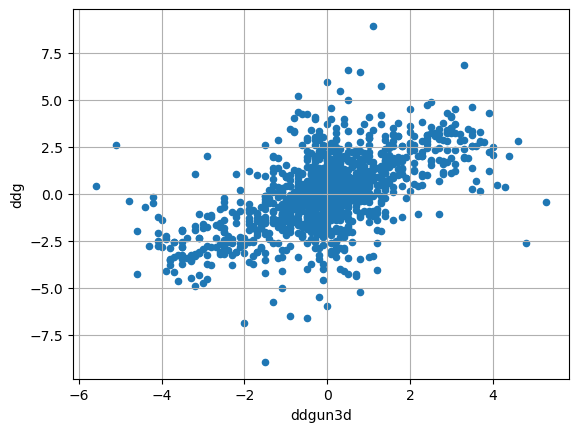

In [43]:
_669_full_clean = _669_full.dropna()
foldx_669_plot = _669_full_clean.plot.scatter(x="ddgun3d", y="ddg", grid=True)

print("RMSE:", math.sqrt(mean_squared_error(_669_full_clean["ddg"], _669_full_clean["ddgun3d"])))
_669_full_clean[['ddg','ddgun3d']].corr()

In [44]:
## Go ddMBC
foldx_s669 = deepcopy(_669_full_clean.apply(rose_delta, axis=1))
foldx_s669

,Protein,mut,ddg,ddgun3d,experimental,s461,from_aa,to_aa,rose_delta
0,1A0FA,S11A,-1.800,0.5,True,True,S,A,-1.0
1,1A7VA,A104H,-2.690,-0.1,True,False,A,H,-69.2
2,1A7VA,A66H,-1.980,0.5,True,False,A,H,-69.2
3,1A7VA,A91H,-1.700,-0.1,True,False,A,H,-69.2
4,1A7VA,D3H,-1.360,0.2,True,False,D,H,-58.0
...,...,...,...,...,...,...,...,...,...
1333,5JXBA,P329D,1.440,0.0,False,True,P,D,-4.9
1334,5OAQA,H429Y,2.990,2.4,False,True,H,Y,-21.9
1335,5VP3A,K39R,-0.413,1.0,False,False,K,R,-46.7
1336,5VP3A,G128S,0.378,0.8,False,False,G,S,-22.7


In [45]:
for _ in sorted(aa_labels):
    foldx_s669[_]=0
foldx_s669=foldx_s669.apply(encode_mutation, axis=1)

In [46]:
X669_optfep= foldx_s669[['ddgun3d']+sorted(aa_labels)].to_numpy()
X669_rose=foldx_s669[['ddgun3d','rose_delta']]
X669_optfep.shape

(1336, 21)

In [47]:
foldx_s669['ddfep_opt']=dd_optfep_model.predict(X669_optfep)
foldx_s669['ddfep_rose']=rose_model.predict(X669_rose)

/usr/local/ivan/Unito/conda/envs/datacrunch/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


ddgun3d S669 RMSE: 1.6077944571577132
ddfep_opt S669 RMSE: 1.841819400853806
ddfep_rose S669 RMSE: 1.6539201534769687


,ddg,ddfep_opt,ddfep_rose
ddg,1.000000,0.498370,0.555651
ddfep_opt,0.498370,1.000000,0.859018
ddfep_rose,0.555651,0.859018,1.000000


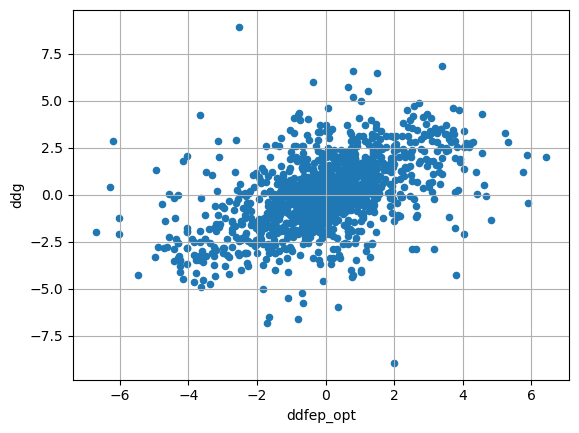

In [48]:
foldx_s669_plot = foldx_s669.plot.scatter(x="ddfep_opt", y="ddg", grid=True)
for _ in ["ddgun3d", "ddfep_opt", "ddfep_rose"]:
    print(
        _, "S669 RMSE:", math.sqrt(mean_squared_error(foldx_s669["ddg"], foldx_s669[_]))
    )
foldx_s669[["ddg", "ddfep_opt", "ddfep_rose"]].corr()

In [49]:
foldx_s669[foldx_s669['experimental'] == True][['ddg','ddgun3d','ddfep_opt','ddfep_rose']].corr()

,ddg,ddgun3d,ddfep_opt,ddfep_rose
ddg,1.000000,0.432432,0.356777,0.421574
ddgun3d,0.432432,1.000000,0.797363,0.981915
ddfep_opt,0.356777,0.797363,1.000000,0.821417
ddfep_rose,0.421574,0.981915,0.821417,1.000000


In [50]:
foldx_s669[foldx_s669['experimental'] == False][['ddg','ddgun3d','ddfep_opt','ddfep_rose']].corr()

,ddg,ddgun3d,ddfep_opt,ddfep_rose
ddg,1.000000,0.410487,0.322365,0.395268
ddgun3d,0.410487,1.000000,0.783068,0.980058
ddfep_opt,0.322365,0.783068,1.000000,0.811108
ddfep_rose,0.395268,0.980058,0.811108,1.000000


## S461

In [51]:
foldx_s461=deepcopy(foldx_s669[ foldx_s669['s461']])
foldx_s461.shape

(922, 31)

In [52]:
print('RMSE ddgun3d:',math.sqrt(mean_squared_error(foldx_s461['ddg'],foldx_s461['ddgun3d'])))

RMSE ddgun3d: 1.1730279421843863


ddgun3d S461 RMSE: 1.1730279421843863
ddfep_opt S461 RMSE: 1.4073585283065733
ddfep_rose S461 RMSE: 1.2307742796071997


,ddg,ddgun3d,ddfep_opt,ddfep_rose
ddg,1.000000,0.743125,0.679995,0.729080
ddgun3d,0.743125,1.000000,0.907048,0.987861
ddfep_opt,0.679995,0.907048,1.000000,0.917031
ddfep_rose,0.729080,0.987861,0.917031,1.000000


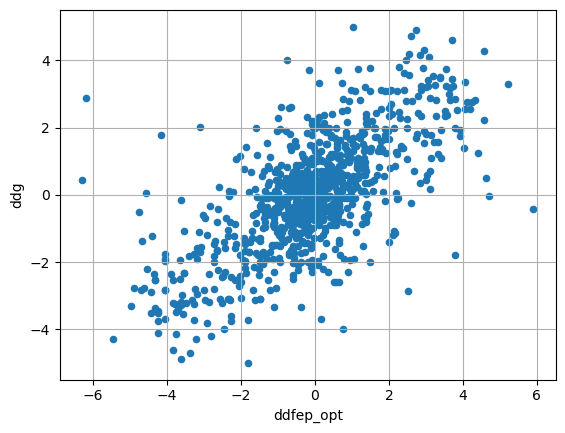

In [53]:
foldx_s461_plot = foldx_s461.plot.scatter(x='ddfep_opt',y='ddg', grid=True)
for _ in ["ddgun3d", "ddfep_opt", "ddfep_rose"]:
    print(
        _, "S461 RMSE:", math.sqrt(mean_squared_error(foldx_s461["ddg"], foldx_s461[_]))
    )
foldx_s461[['ddg','ddgun3d','ddfep_opt','ddfep_rose']].corr()

In [54]:
foldx_s461[foldx_s461['experimental'] == True][['ddg','ddgun3d','ddfep_opt','ddfep_rose']].corr()

,ddg,ddgun3d,ddfep_opt,ddfep_rose
ddg,1.000000,0.619281,0.545276,0.612378
ddgun3d,0.619281,1.000000,0.871981,0.983661
ddfep_opt,0.545276,0.871981,1.000000,0.886140
ddfep_rose,0.612378,0.983661,0.886140,1.000000


In [55]:
foldx_s461[foldx_s461['experimental'] == False][['ddg','ddgun3d','ddfep_opt','ddfep_rose']].corr()

,ddg,ddgun3d,ddfep_opt,ddfep_rose
ddg,1.000000,0.572336,0.477793,0.558210
ddgun3d,0.572336,1.000000,0.859983,0.981912
ddfep_opt,0.477793,0.859983,1.000000,0.877564
ddfep_rose,0.558210,0.981912,0.877564,1.000000
